In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from scipy.misc import imread, imsave
import cPickle as pickle
import yaml
import collections
from tqdm import tqdm
import time
from scipy.ndimage.interpolation import zoom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Making the icons

In [11]:
import pandas as pd

In [3]:
def mine_to_ali(name):
    mapper = {'CM167PN': 'CM167NP', 'SE1_2RT_7': 'SE12RT-1', 'SE1_2RT_10': 'SE12RT-2'}
    
    if name in mapper:
        return mapper[name]
    else:
        return name.replace('_', '')

In [4]:
loadpath = '/home/michael/Dropbox/engage/FairbrassFirmanetal_/data/predictions/massive_dataset/per_site_summaries.csv'

df_in = pd.read_csv(loadpath)

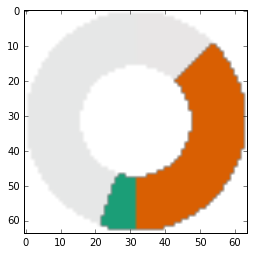

In [21]:
savedir = './mapapp/assets/sites/charts/'

bio_col = np.array([27, 158, 119, 255]) / 255.0
anthro_col = np.array([217, 95, 2, 255]) / 255.0
black = np.array([0, 0, 0, 1.0])

for idx, row in df_in.iterrows():
#     print row

    if 0:
        im = np.ones((64, 64, 4))
        im[:, :, -1] = 0

        h_anthro = 64 - int(row['anthrop'] * 60)
        h_bio = 64 - int(row['biotic'] * 60)

        im[h_bio:, :32, :] = bio_col
        im[h_anthro:, 32:, :] = anthro_col

    else:
        w = 64
        l= np.linspace(-1.0, 1.0, w)
        x, y = np.meshgrid(l, l)
        r = np.sqrt(x**2 + y**2)

        outer_mask = r < 1.0
        inner_mask = r > 0.5
        both = np.logical_and(outer_mask, inner_mask)

        angle = np.mod(np.arctan2(y, x) - np.pi/2, 2*np.pi)
        anthro_cut = row['anthrop'] * np.pi
        bio_cut = row['biotic'] * np.pi

        bio_mask = angle < bio_cut
        anthro_mask = (2 * np.pi - angle) < anthro_cut

        bio_mask = np.logical_and(bio_mask, both)
        anthro_mask = np.logical_and(anthro_mask, both)

        im = np.ones((64, 64, 4))
        im[:, :, -1] = 0
        
        mask = np.logical_and(both, x <  0)
        im[mask, :] = bio_col
        im[mask, -1] = 0.1
        
        mask = np.logical_and(both, x > 0)
        im[mask, :] = anthro_col
        im[mask, -1] = .1
        
        im[bio_mask, :] = bio_col
        im[anthro_mask, :] = anthro_col

    imsave(savedir + '%s.png' % mine_to_ali(row['Unnamed: 0']), im)
    

plt.imshow(im)

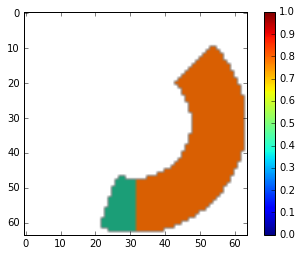

In [42]:
w = 64
l= np.linspace(-1.0, 1.0, w)
x, y = np.meshgrid(l, l)
r = np.sqrt(x**2 + y**2)

outer_mask = r < 1.0
inner_mask = r > 0.5
both = np.logical_and(outer_mask, inner_mask)

angle = np.mod(np.arctan2(y, x) - np.pi/2, 2*np.pi)
anthro_cut = row['anthrop'] * np.pi
bio_cut = row['biotic'] * np.pi

bio_mask = angle < bio_cut
anthro_mask = (2 * np.pi - angle) < anthro_cut

bio_mask = np.logical_and(bio_mask, both)
anthro_mask = np.logical_and(anthro_mask, both)

im = np.ones((64, 64, 4))
im[:, :, -1] = 0

im[bio_mask, :] = bio_col
im[anthro_mask, :] = anthro_col


plt.imshow(im)



plt.colorbar()

# Getting audio files

In [8]:
sys.path.append('../prediction/apply_to_massive/')
import utils
import shutil

search_locations = utils.get_search_locations()
to_exclude = ['Card slot', 'copy', 'Sliced', '250515-010615', 'NOISE']

site_to_audio_fname = {}

for hd_idx, search_location in search_locations:

    for root, dirnames, filenames in os.walk(search_location):
        
        if 'E29' in root:
            sitename = 'E29RR'
        else:
            sitename = root.replace('/SM2+', '').split('/')[-1]
            
        if sitename in site_to_audio_fname or any(xx in sitename for xx in to_exclude):
            continue
        
        sitename = mine_to_ali(sitename)

        filtered_fnames = [fname for fname in filenames
                          if 'BAT+' not in root and 'Random' not in root and fname.endswith('.wav')]
        
        if len(filtered_fnames):
            site_to_audio_fname[sitename] = (root, filtered_fnames[0])
            shutil.copy(root + '/'+ filtered_fnames[0], savedir)
            
            print ".",
            sys.stdout.flush()

['/media/michael/Elements1/', '/media/michael/Elements2/', '/media/michael/Elements/']
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [13]:
from scipy.io import wavfile
savedir = './mapapp/assets/sites/audio/'

for xx, (root, fname) in site_to_audio_fname.items():
    
    rate, data = wavfile.read(root + '/' + fname)
    
    # only save 30 seconds
    length = 30 * rate
    
    wavfile.write(savedir + fname, rate, data[:length])

# Making csv file

In [12]:
# Loading coords
site_coords = pd.read_csv('/media/michael/Engage/data/audio/alison_data/sites/allSitesDetailsCoordinates.csv')
    
final = []
for idx, row in site_coords.iterrows():
    lat = row['Lat']
    lon = row['Long']
    if lat == '51.30.16N':
        lat = 51.504444
    if lon == '0.4.50W':
        lon = -0.080556
    elif lon == '0.4.53W':
        lon = -0.081389

    lat = float(lat)
    lon = float(lon)
    audio_fname = site_to_audio_fname[row['SiteCode']][1]#.replace('.wav', '.mp3')
    final.append([row['SiteCode'], lat, lon, audio_fname, row['Site_Name']])
    

df = pd.DataFrame(final)
df.to_csv('./mapapp/assets/sites/sites_info.csv', header=False, index=False)

NameError: name 'site_to_audio_fname' is not defined

# Saving images

In [74]:
base_folder = '/media/michael/Engage/data/audio/alison_data/sites/sitePhotos/'
out_size = 600
savedir = './mapapp/assets/sites/ims/'

In [83]:
import cv2

In [97]:
from scipy.misc import imresize
for fname in os.listdir(base_folder):
    
    im_sitename = fname.split('.')[0]
    im = imread(base_folder + fname)
    if im_sitename == 'RM143YB':
        im = im.transpose(1, 0, 2)[::-1, :, :]
    dst = None
    im = cv2.resize(im, dst, fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)

    imsave(savedir + im_sitename + '.jpg', im)
    #cv2.imwrite(savedir + im_sitename + '_.jpg', im)

In [71]:
print sorted(site_to_audio_fname.keys())

['BR20EG', 'BR28LB', 'BR4', 'BR67US', 'CM167NP', 'CR0', 'CR01SG', 'CR05EF', 'CR8', 'DA5', 'E105JP', 'E10NR', 'E140EY', 'E29RR', 'E47EN', 'HA53AA', 'HA86RB', 'IG110FJ', 'IG62XL', 'KT186AP', 'N17', 'N29BX', 'N41ES', 'N88JD', 'NW1', 'NW10TA', 'NW23SH', 'NW32BZ', 'NW33RY', 'RM143YB', 'RM154HX', 'RM25EL', 'RM41LD', 'RM41PL', 'SE109EY', 'SE116DN', 'SE12RT-1', 'SE12RT-2', 'SE154EE', 'SE220SD', 'SE23', 'SE232NZ', 'SE3', 'SE41SA', 'SE6', 'SE64PL', 'SE84EA', 'SW112PN', 'SW154JY', 'SW154LA', 'SW1E6BN', 'SW1W0QP', 'SW66DU', 'TN147QB', 'TW76BE', 'TW76ER', 'W112NN', 'W1T4BQ', 'W42PH', 'W55EQ', 'W84LA', 'WC2H8LG', 'WC2N6RH']


# Converting files to mp3

In [3]:
import subprocess as sp

In [8]:
# base_in = './mapapp/assets/sites/audio/'
# base_out = './mapapp/assets/sites/audio_mp3/'

base_in = './mapapp/assets/info/'
base_out = './mapapp/assets/info/'


for fname in os.listdir(base_in):
    sp.call(['lame', base_in + fname, base_out + fname.replace('.wav', '.mp3')])